In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.sql.functions import col
from pyspark.sql.functions import desc
import numpy as np

In [2]:
spark = SparkSession.builder.appName("U-Pick").getOrCreate()
ruta_modelo="file:////home/student/SIC_Big_Data_CDC-develop-chris/ModeloEntrenado"
modelo_cargado=CrossValidatorModel.load(ruta_modelo)

In [3]:
tweets = spark.read.table('proyecto_final.tweets')

2023-07-27 01:33:54,215 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-07-27 01:33:54,215 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-07-27 01:33:55,126 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


In [4]:
predicciones_df=modelo_cargado.transform(tweets)

In [5]:
mydb = mysql.connector.connect(
    host="localhost",
    user="student",
    password="student")
print(mydb)

In [6]:
mycursor = mydb.cursor()
mycursor.execute("USE proyecto_final")

In [48]:
ids= [41, 18, 11];
grado = 'Informática'
areas=[1,2,3]
query="select id, posicion_hindex, siglas from Universidades where id = %s or id = %s or id = %s"
mycursor.execute(query, (ids[0], ids[1], ids[2]))
hindexes= []
siglas =[]
for x in mycursor:
    if x[1] is None:
        hindexes.append(0)
    else:
        hindexes.append(130-x[1])
    siglas.append(x[2])

/tmp/ipykernel_6532/3551041902.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([130, 110, 90, 70, 50, 30, 10])


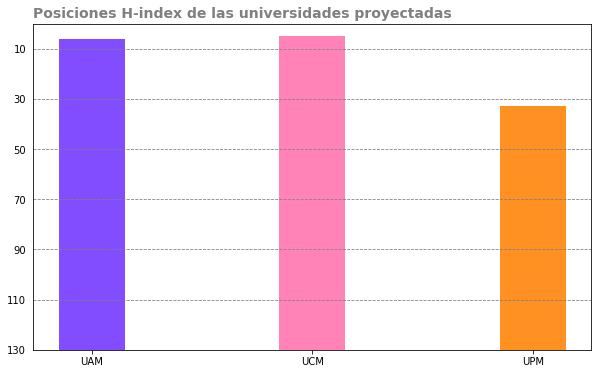

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_yticklabels([130, 110, 90, 70, 50, 30, 10])
paleta=['#814DFF', '#FF83B6', '#FF9022']
ax.bar(siglas, hindexes, width=0.3,color=paleta)
ax.tick_params(left=False)
ax.set_ylim(0,130)
ax.set_title('Posiciones H-index de las universidades proyectadas', loc = 'left', fontdict={'fontsize':14, 'fontweight':'bold', 'color':'gray'})
ax.grid(axis ='y', color = 'gray', linestyle = 'dashed')

In [9]:
df_satisfaccion = pd.DataFrame(columns=['siglas', 'satisfaccion'])
for x in siglas:
    satisfaccion_df = predicciones_df.select("siglas", "prediction").where(predicciones_df['siglas']==x).groupby("siglas").mean("prediction")
    satisfaccion_df_pd = satisfaccion_df.toPandas()
    satisfaccion_df_pd.rename(columns={'avg(prediction)':'satisfaccion'}, inplace = True)
    porcentaje = [x*100 for x in satisfaccion_df_pd['satisfaccion']]
    satisfaccion_df_pd['satisfaccion'] = porcentaje
    df_satisfaccion = pd.concat([df_satisfaccion, satisfaccion_df_pd], ignore_index=True)
df_satisfaccion

,siglas,satisfaccion
0,UAM,40.000000
1,UCM,71.428571
2,UPM,44.444444


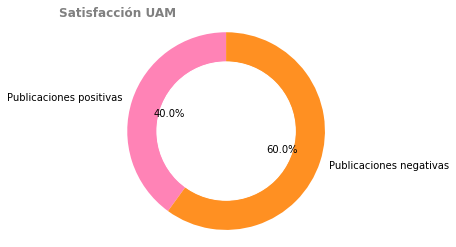

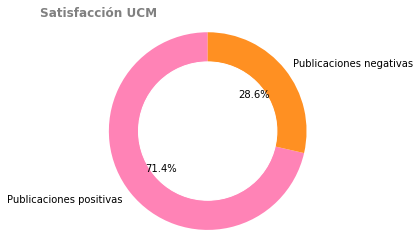

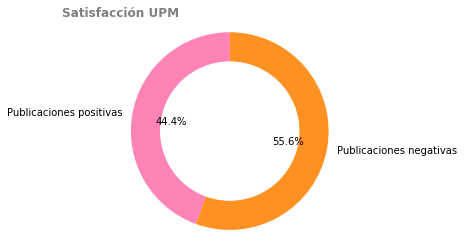

In [10]:
for sigla, porcentaje in zip(df_satisfaccion['siglas'], df_satisfaccion['satisfaccion']):
    categorias = ['Publicaciones positivas', 'Publicaciones negativas']
    valores = [porcentaje, 100-porcentaje]
    colores_pasteles = ['#FF83B6', '#FF9022']
    fig, ax = plt.subplots() 
    pie = ax.pie(valores, labels=categorias, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3), colors=colores_pasteles)
    centro_circulo = plt.Circle((0, 0), 0.70, color='white') 
    ax.add_artist(centro_circulo)
    ax.axis('equal')
    ax.set_title('Satisfacción '+sigla, loc = 'left', fontdict={'fontsize':12, 'fontweight':'bold', 'color':'gray'})
    plt.show()

In [16]:
query = "select Universidades.siglas, Grados.empleabilidad, Grados.nombre, Grados.nota_corte, Grados.nota_corte_ant from Universidades \
    join Facultades on Universidades.id=Facultades.id_univ \
    join Grados on Facultades.id=Grados.id_fac \
    where Grados.nombre LIKE %s and (Universidades.id = %s or Universidades.id = %s or Universidades.id = %s)"
val = ('%'+grado+'%', ids[0], ids[1], ids[2])
mycursor.execute(query, val)
grados=[]
empleabilidad=[]
notaCorte=[]
prevNotaCorte=[]
for x in mycursor:
    if x[1] is None:
        empleabilidad.append(0)
    else:
        empleabilidad.append(x[1])
    grados.append(x[2]+ ' '+x[0])
    if x[3] is None:
        notaCorte.append(0)
    else:
        notaCorte.append(x[3])
    if x[4] is None:
        prevNotaCorte.append(0)
    else:
        prevNotaCorte.append(x[4])

/tmp/ipykernel_6532/3084025728.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(grados, rotation =45, ha='right')


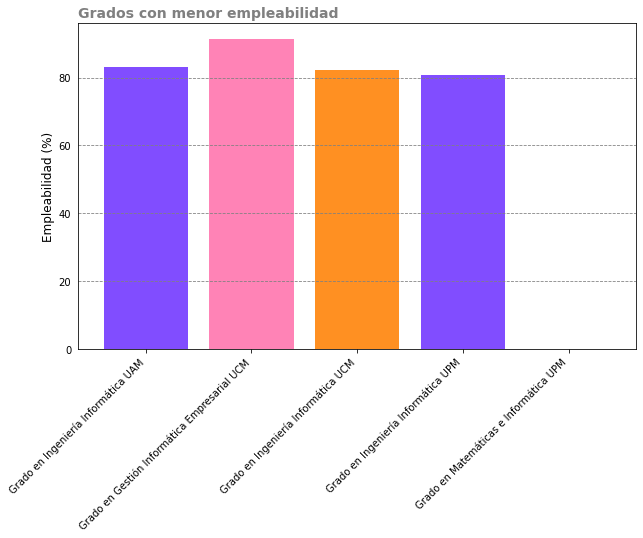

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
paleta=['#814DFF', '#FF83B6', '#FF9022']
ax.bar(grados, empleabilidad, color=paleta)
ax.tick_params(left=False)
ax.set_xticklabels(grados, rotation =45, ha='right')
plt.ylabel('Empleabilidad (%)', fontsize=12)
ax.set_title('Grados con menor empleabilidad', loc = 'left', fontdict={'fontsize':14, 'fontweight':'bold', 'color':'gray'})
ax.grid(axis ='y', color = 'gray', linestyle = 'dashed')

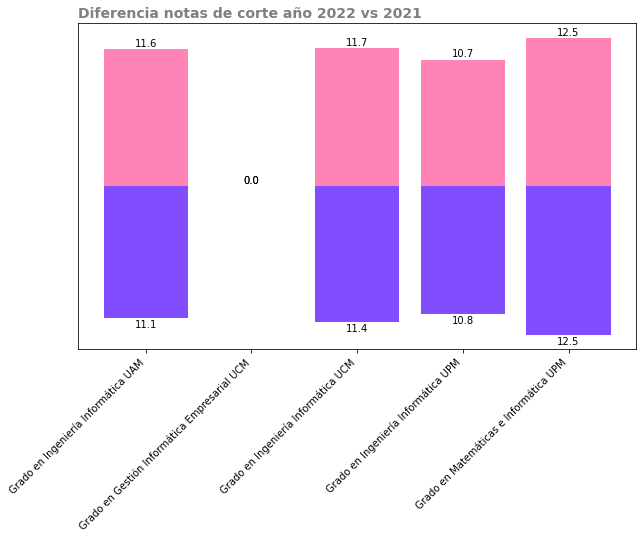

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xticks(np.arange(len(grados)))
ax.set_xticklabels(grados,rotation=45,ha='right')
ax.set_yticks([])
rect_actuales= ax.bar(np.arange(len(grados)), notaCorte, label='Notas actuales', color='#FF83B6')
rect_antes= ax.bar(np.arange(len(grados)), [-y for y in prevNotaCorte], label='Notas previas', color='#814DFF')
for rect in rect_actuales + rect_antes:
    height=rect.get_height()
    if height>=0:
        ax.text(rect.get_x() + rect.get_width() / 2., height + 0.1, f'{height:.1f}', ha='center', va='bottom')
    else:
        ax.text(rect.get_x() + rect.get_width() / 2., height - 0.1, f'{abs(height):.1f}', ha='center', va='top')
ax.set_title('Diferencia notas de corte año 2022 vs 2021', loc = 'left', fontdict={'fontsize':14, 'fontweight':'bold', 'color':'gray'})
plt.show()

In [50]:
mycursor.execute("select id, nombre from Campos")
campos = dict()
for x in mycursor:
    campos[x[0]]=x[1]
query="select id_univ, id_campo, puntuacion from Rankings where (id_campo=%s or id_campo=%s or id_campo=%s) and (id_univ=%s or id_univ=%s or id_univ=%s) order by id_campo asc"
val=(areas[0],areas[1],areas[2],ids[0],ids[1],ids[2])
mycursor.execute(query,val)
puntuacion1 = [];
puntuacion2 = [];
puntuacion3 = [];
for x in mycursor:
    if x[0] == ids[0]:
        if x[2] is None:
            puntuacion1.append(0)
        else:
            puntuacion1.append(x[2])
    elif x[0] == ids[1]:
        if x[2] is None:
            puntuacion2.append(0)
        else:
            puntuacion2.append(x[2])
    elif x[0] == ids[2]:
        if x[2] is None:
            puntuacion3.append(0)
        else:
            puntuacion3.append(x[2])
puntuaciones = [puntuacion1, puntuacion2, puntuacion3]

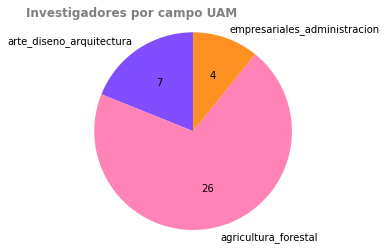

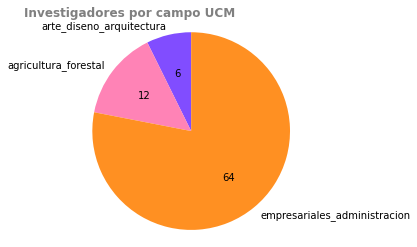

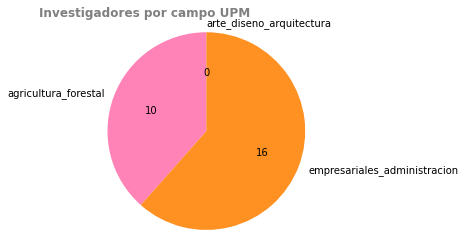

In [60]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format
for sigla, puntuacion in zip(siglas, puntuaciones):
    categorias = [campos.get(areas[0]), campos.get(areas[1]), campos.get(areas[2])]
    valores = puntuacion
    fig, ax = plt.subplots() 
    pie = ax.pie(valores, labels=categorias, autopct=autopct_format(valores), startangle=90, colors=paleta)
    ax.axis('equal')
    ax.set_title('Investigadores por campo '+sigla, loc = 'left', fontdict={'fontsize':12, 'fontweight':'bold', 'color':'gray'})
    plt.show()